In [37]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os
import random

In [38]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/brain-tumor-mri-dataset


##Data Exploration

In [39]:
training_dir = os.path.join(path, "Training")
testing_dir = os.path.join(path, "Testing")

print("Training dataset image counts:")
for i in os.listdir(training_dir):
    subdir_path = os.path.join(training_dir, i)
    if os.path.isdir(subdir_path):
        image_count = sum([len(files) for r, d, files in os.walk(subdir_path)])
        print(f"- {i}: {image_count} images")

print("\nTesting dataset image counts:")
for i in os.listdir(testing_dir):
    subdir_path = os.path.join(testing_dir, i)
    if os.path.isdir(subdir_path):
        image_count = sum([len(files) for r, d, files in os.walk(subdir_path)])
        print(f"- {i}: {image_count} images")

Training dataset image counts:
- pituitary: 1457 images
- notumor: 1595 images
- meningioma: 1339 images
- glioma: 1321 images

Testing dataset image counts:
- pituitary: 300 images
- notumor: 405 images
- meningioma: 306 images
- glioma: 300 images


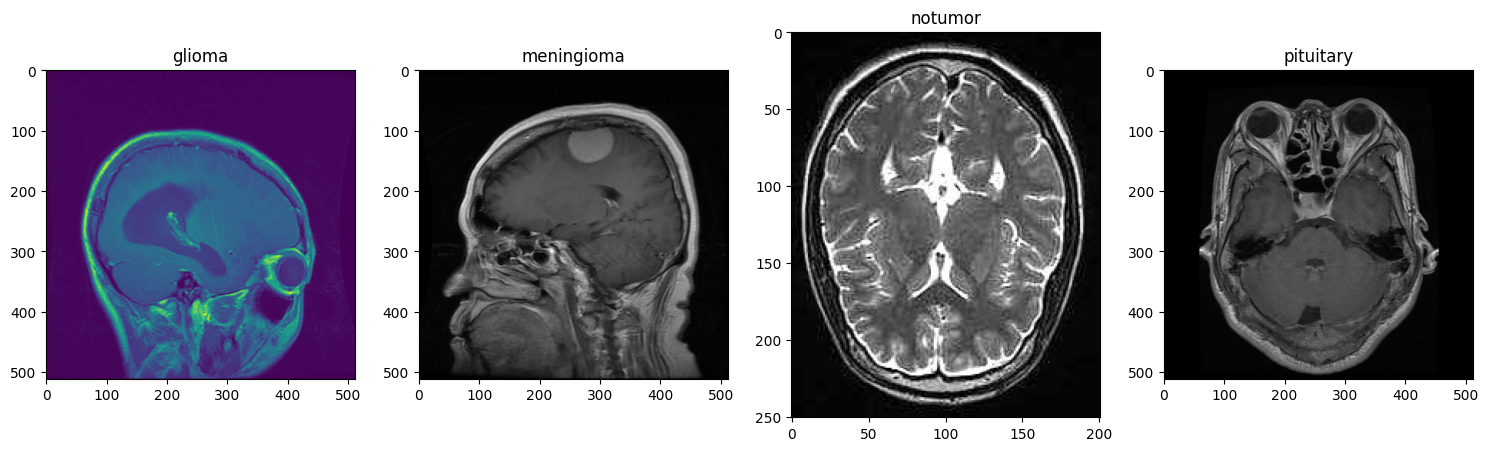

In [40]:
tumor_types = ['glioma', 'meningioma', 'notumor', 'pituitary']
fig, axes = plt.subplots(1, len(tumor_types), figsize=(15, 5))
for i, tumor_type in enumerate(tumor_types):

    tumor_dir = os.path.join(training_dir, tumor_type)
    image_files = [f for f in os.listdir(tumor_dir) if os.path.isfile(os.path.join(tumor_dir, f))]
    random_image_file = random.choice(image_files)
    random_image_path = os.path.join(tumor_dir, random_image_file)
    img = Image.open(random_image_path)
    axes[i].imshow(img)
    axes[i].set_title(tumor_type)

plt.tight_layout()
plt.show()

In [42]:
X_train = []
y_train = []
X_test = []
y_test = []

# target size for resizing images
target_size = (225, 225)

for tumor_type in tumor_types:
    train_tumor_dir = os.path.join(training_dir, tumor_type)
    test_tumor_dir = os.path.join(testing_dir, tumor_type)

    for image_file in os.listdir(train_tumor_dir):
        image_path = os.path.join(train_tumor_dir, image_file)
        img = Image.open(image_path)
        img_gray = img.convert('L')
        img_resized = img_gray.resize(target_size)
        img_array = np.array(img_resized)
        X_train.append(img_array)
        y_train.append(tumor_type)

    for image_file in os.listdir(test_tumor_dir):
        image_path = os.path.join(test_tumor_dir, image_file)
        img = Image.open(image_path)
        img_gray = img.convert('L')
        img_resized = img_gray.resize(target_size)
        img_array = np.array(img_resized)
        X_test.append(img_array)
        y_test.append(tumor_type)

X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

## Load and preprocess data


In [51]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Change target size to 224x224
test_datagen = ImageDataGenerator(rescale=1./224)
target_size = (224, 224)
batch_size = 32

train_generator = train_datagen.flow_from_directory(
    training_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    testing_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False # Keep data in order for evaluation
)

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [52]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input

# Define the input shape based on the target size and grayscale images
input_shape = (target_size[0], target_size[1], 1)
input_tensor = Input(shape=input_shape)

# Load the ResNet50 model without the top layer and with pre-trained weights
# Use a dummy input tensor with 3 channels temporarily to load the weights
# We will handle the grayscale conversion later in the model
base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(target_size[0], target_size[1], 3)))

# Make the layers of the base model non-trainable
for layer in base_model.layers:
    layer.trainable = False

## Add custom classification layers



In [53]:
from keras.applications import ResNet50
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.optimizers import Adam

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3)) # Ensure input shape is 224x224 with 3 channels

# Freeze base model layers initially
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)  # Dropout for regularization
predictions = Dense(4, activation='softmax')(x)  # Assuming 4 tumor classes

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

## Compile the model


In [54]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy

# Compile the model
model.compile(optimizer=Adam(),
              loss=CategoricalCrossentropy(),
              metrics=['accuracy'])

## Train the model



In [ ]:
#random epoch value
epochs = 10
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=test_generator
)

Epoch 1/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 105s 518ms/step - accuracy: 0.3817 - loss: 1.3455 - val_accuracy: 0.3066 - val_loss: 1.7925
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 89s 497ms/step - accuracy: 0.4475 - loss: 1.1477 - val_accuracy: 0.3692 - val_loss: 1.3542
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 91s 506ms/step - accuracy: 0.4546 - loss: 1.1262 - val_accuracy: 0.3997 - val_loss: 1.4357
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 88s 493ms/step - accuracy: 0.4968 - loss: 1.0933 - val_accuracy: 0.3822 - val_loss: 1.5713
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 132s 439ms/step - accuracy: 0.4911 - loss: 1.0799 - val_accuracy: 0.4005 - val_loss: 1.4967
Epoch 6/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 78s 436ms/step - accuracy: 0.5133 - loss: 1.0638 - val_accuracy: 0.4150 - val_loss: 1.5217
Epoch 7/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 80s 445ms/step - accuracy: 0.5053 - loss: 1.0699 - val_accuracy: 0.4241 - val_loss: 1.5249
Epoch 8/10
 97/179 ━━━━━━━━━━━━━━━━━━━━ 35s 438ms/step - accuracy: 0.5069 - loss:

## Create confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

true_labels = test_generator.classes
predictions = model.predict(test_generator)

# Get the predicted labels by taking the index with the highest probability
predicted_labels = np.argmax(predictions, axis=1)

In [ ]:
cm = confusion_matrix(true_labels, predicted_labels)
class_labels = list(test_generator.class_indices.keys())

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()